### Description of notebook

In this notebook, I implement Deep Successor Reinforcement Learning by Tejas D. Kulkarni, Ardavan Saeedi, Simanta Gautam, Samuel J. Gershman. ([link](https://arxiv.org/abs/1606.02396))

### Loading required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import gym
import math
import random
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from skimage.transform import resize

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Testing the environment

In [2]:
import random
import numpy as np
import gym
from gym_minigrid.register import env_list
from gym_minigrid.minigrid import Grid, OBJECT_TO_IDX

# Test specifically importing a specific environment
from gym_minigrid.envs import DoorKeyEnv

# Test importing wrappers
from gym_minigrid.wrappers import *

##############################################################################

print('%d environments registered' % len(env_list))

for env_name in env_list:
    print('testing "%s"' % env_name)

    # Load the gym environment
    env = gym.make(env_name)
    env.max_steps = min(env.max_steps, 200)
    env.reset()
    env.render('rgb_array')

    # Verify that the same seed always produces the same environment
    for i in range(0, 5):
        seed = 1337 + i
        env.seed(seed)
        grid1 = env.grid
        env.seed(seed)
        grid2 = env.grid
        assert grid1 == grid2

    env.reset()
    
    break

    # Run for a few episodes
    num_episodes = 0
    while num_episodes < 5:
        # Pick a random action
        action = random.randint(0, env.action_space.n - 1)

        obs, reward, done, info = env.step(action)

        # Validate the agent position
        assert env.agent_pos[0] < env.width
        assert env.agent_pos[1] < env.height

        # Test observation encode/decode roundtrip
        img = obs['image']
        vis_mask = img[:, :, 0] != OBJECT_TO_IDX['unseen']  # hackish
        img2 = Grid.decode(img).encode(vis_mask=vis_mask)
        assert np.array_equal(img, img2)

        # Test the env to string function
        str(env)

        # Check that the reward is within the specified range
        assert reward >= env.reward_range[0], reward
        assert reward <= env.reward_range[1], reward

        if done:
            num_episodes += 1
            env.reset()

        env.render('rgb_array')
        break

    # Test the close method
    env.close()

    env = gym.make(env_name)
    env = ReseedWrapper(env)
    for _ in range(10):
        env.reset()
        env.step(0)
        env.close()

    env = gym.make(env_name)
    env = ImgObsWrapper(env)
    env.reset()
    env.step(0)
    env.close()

    # Test the fully observable wrapper
    env = gym.make(env_name)
    env = FullyObsWrapper(env)
    env.reset()
    obs, _, _, _ = env.step(0)
    assert obs.shape == env.observation_space.shape
    env.close()

    env = gym.make(env_name)
    env = FlatObsWrapper(env)
    env.reset()
    env.step(0)
    env.close()

    env = gym.make(env_name)
    env = AgentViewWrapper(env, 5)
    env.reset()
    env.step(0)
    env.close()

##############################################################################

print('testing agent_sees method')
env = gym.make('MiniGrid-DoorKey-6x6-v0')
goal_pos = (env.grid.width - 2, env.grid.height - 2)

# Test the "in" operator on grid objects
assert ('green', 'goal') in env.grid
assert ('blue', 'key') not in env.grid

# Test the env.agent_sees() function
env.reset()
for i in range(0, 500):
    action = random.randint(0, env.action_space.n - 1)
    obs, reward, done, info = env.step(action)
    goal_visible = ('green', 'goal') in Grid.decode(obs['image'])
    agent_sees_goal = env.agent_sees(*goal_pos)
    assert agent_sees_goal == goal_visible
    if done:
        env.reset()
        break

68 environments registered
testing "MiniGrid-Empty-5x5-v0"
testing agent_sees method


### Testing the envir

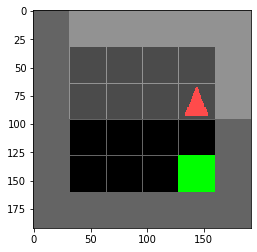

In [3]:
env = gym.make('MiniGrid-Empty-Random-6x6-v0')
# env.seed(108)
obs = env.reset()
# print(env.render(mode='rgb_array'))

plt.imshow(env.render(mode='rgb_array')); plt.show()


0 False


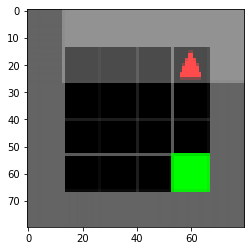

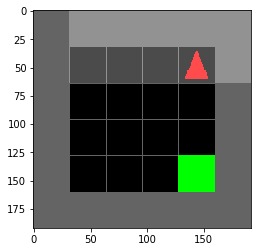

In [4]:
_, R, done, _ = env.step(env.action_space.sample())
print(R,done)
plt.imshow(resize(env.render(mode='rgb_array'), (80,80), anti_aliasing=False)); plt.show()
plt.imshow(env.render(mode='rgb_array')); plt.show()

### Implementing neural network in torch for FA

In [5]:
class thetaNet(nn.Module):

    def __init__(self, h=80, w=80, outputs=16):
        super(thetaNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(16)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 16
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
class theta2Net(nn.Module): # decoder for thetaNet
    
    
    
    def forward(self, x):
        return x
    
class alphaNet(nn.Module):

    def __init__(self, in_size=16, actions=3):
        super(alphaNet, self).__init__()
        self.head11 = nn.Linear(in_size, in_size)
        self.head12 = nn.Linear(in_size, in_size)
        self.head21 = nn.Linear(in_size, in_size)
        self.head22 = nn.Linear(in_size, in_size)
        self.head31 = nn.Linear(in_size, in_size)
        self.head32 = nn.Linear(in_size, in_size)
        self.actions = actions

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x1 = F.relu(self.head12(F.relu(self.head11(x))))
        x2 = F.relu(self.head22(F.relu(self.head11(x))))
        x3 = F.relu(self.head32(F.relu(self.head11(x))))
        x = torch.cat((x1, x2, x3), 1)
        return x.view(x.size(0), self.actions, -1)
    
class wNet(nn.Module):

    def __init__(self, in_size=16):
        super(wNet, self).__init__()
        self.head = nn.Linear(in_size, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.head(x)

### Implementing replay memory

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Setting up networks and optimization procedures

In [7]:
tnet = thetaNet().to(device); anet = alphaNet().to(device); wnet = wNet().to(device); 
anet_target = alphaNet().to(device); anet_target.load_state_dict(anet.state_dict()); anet_target.eval()

tw_params = list(tnet.parameters()) + list(wnet.parameters())
ta_params = list(tnet.parameters()) + list(anet.parameters())
optimizer1 = optim.Adam(tw_params, lr=0.005)
optimizer2 = optim.Adam(anet.parameters(), lr=0.005)
memory = ReplayMemory(1000)

### Creating select action method

In [8]:
steps_done = 0
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 2000
TARGET_UPDATE = 10
eps_threshold = 1
EXPLORE_FOR = 1000

def select_action(phi, w):
    global steps_done
    global eps_threshold
    sample = random.random()
    if(steps_done > EXPLORE_FOR):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
#             return policy_net(state).max(1)[1].view(1, 1)
            aout = anet(phi)
            return aout.matmul(w).max(1)[1] #maybe add .view(1,1)
    else:
#         import pdb; pdb.set_trace();
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

### Setting up environment

In [9]:
def get_screen(env):
    k = env.render(mode='rgb_array')
    k = resize(k, (80,80), anti_aliasing=False)
    k = torch.Tensor(k)
    k = k.permute(2,1,0).unsqueeze(0)
    k = k.to(device)
    return k

(256, 256, 3)


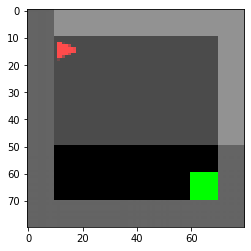

In [10]:
from gym_minigrid.envs import EmptyEnv


env = EmptyEnv()
k = env.render(mode='rgb_array')
print(k.shape)
plt.imshow(resize(k, (80,80), anti_aliasing=False))

### Optimization function

In [11]:
loss = nn.MSELoss()
L_r_vec = []
L_m_vec = []
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    
#     import pdb; pdb.set_trace()
    
    # Computing the reward loss L_r
    L_r = F.smooth_l1_loss(reward_batch, wnet(tnet(state_batch)).squeeze(1))
    L_r_vec.append(L_r.item())
    
    # Optimize the model
    optimizer1.zero_grad()
    L_r.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer1.step()
    
    # Computing the SF loss
    U_observed = anet(tnet(state_batch))[torch.arange(0, BATCH_SIZE),action_batch.squeeze(),:]
    
    action_max = anet(tnet(state_batch)).matmul(wnet.head.weight.data.view(-1,1)).max(1)[1]
    U_estimated = anet_target(tnet(state_batch))[torch.arange(0, BATCH_SIZE),action_max.squeeze(),:] 
    
    L_m = loss(U_observed, U_estimated)
    L_m_vec.append(L_m.item())
    
    # Optimize the model
    optimizer2.zero_grad()
    L_m.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer2.step()

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
#     state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
#     next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
#     expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
#     loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    

### Main code

In [12]:
# Initializations: Line 1
num_episodes = 100 # CHANGE
n_actions = 3
R_eps = []
ed = []; eps_vec = [];

for i_episode in range(num_episodes): # Line 2
    if(i_episode>1):
        print('episode: {}/{}, time={}, reward={}, eps={}'.format(i_episode, num_episodes, ed[-1], R, eps_threshold))
    R = 0
    
    # Initialize the environment and state: Line 3
    env.reset() # <TODO: random initial location>
    state = get_screen(env)
    
    for t in count(): # Line 4
#         print(t, action)
        
        # Find abstracted states: Line 5
        phi = tnet(state)
        
        # Select an action: Line 6
        action = select_action(phi, wnet.head.weight.data.view(-1,1))
        
        # Perform an action: Line 7
        _, reward, done, _ = env.step(action.item())
        R = R + reward
        reward = torch.tensor([reward], device=device).float()
        next_state = get_screen(env)
        
        # Store the transition in memory: Line 8
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Lines 9 - 11
        optimize_model() # TODO
        
        # Additional tracking
        if done:
            ed.append(t+1)
            R_eps.append(R)
            eps_vec.append(eps_threshold)
            break
            
    if i_episode % TARGET_UPDATE == 0:
        anet_target.load_state_dict(anet.state_dict())

episode: 2/100, time=256, reward=0, eps=1
episode: 3/100, time=150, reward=0.47265625, eps=1
episode: 4/100, time=136, reward=0.521875, eps=1
episode: 5/100, time=82, reward=0.71171875, eps=1
episode: 6/100, time=113, reward=0.602734375, eps=1
episode: 7/100, time=256, reward=0, eps=0.5590071097840833
episode: 8/100, time=256, reward=0, eps=0.4978516255521743
episode: 9/100, time=185, reward=0.349609375, eps=0.45828358106379125
episode: 10/100, time=19, reward=0.933203125, eps=0.45442325263655764
episode: 11/100, time=87, reward=0.694140625, eps=0.43720798770559577
episode: 12/100, time=142, reward=0.50078125, eps=0.41066948487517163
episode: 13/100, time=83, reward=0.708203125, eps=0.39600803059294715
episode: 14/100, time=99, reward=0.6519531249999999, eps=0.37929762747194656
episode: 15/100, time=90, reward=0.68359375, eps=0.36480770263679513
episode: 16/100, time=256, reward=0, eps=0.3269846209457465
episode: 17/100, time=256, reward=0, eps=0.29370585471021327
episode: 18/100, time

KeyboardInterrupt: 

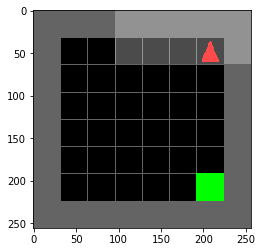

In [13]:
plt.imshow(env.render(mode='rgb_array'))

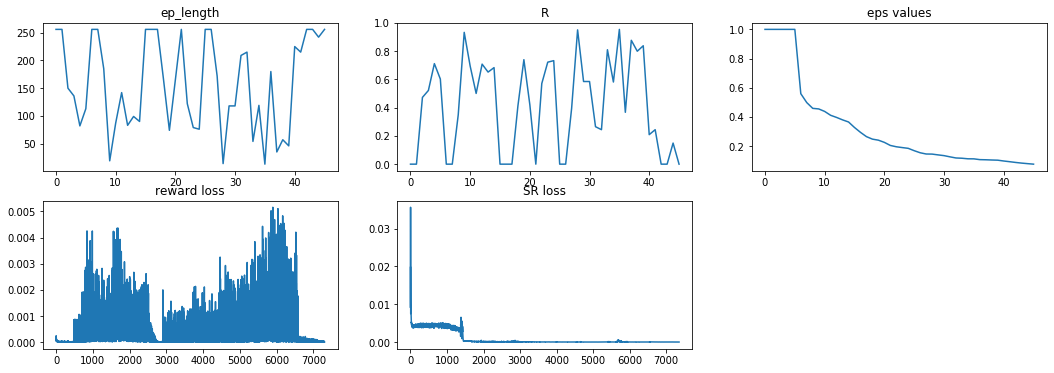

In [15]:
def visualize_results():
    plt.figure(figsize=(18,6))
    plt.subplot(2,3,1); plt.plot(ed); plt.title('ep_length');
    plt.subplot(2,3,2); plt.plot(R_eps); plt.title('R'); 
    plt.subplot(2,3,3); plt.plot(eps_vec); plt.title('eps values'); 
    plt.subplot(2,3,4); plt.plot(L_r_vec[50:]); plt.title('reward loss'); 
    plt.subplot(2,3,5); plt.plot(L_m_vec); plt.title('SR loss'); plt.show()
#     plt.subplot(2,3,6); plt.plot(); plt.title(''); plot.show()

visualize_results()

In [ ]:
def sanity_check():
    env.reset()
    eps_threshold = 1
    iterations = 15
    for i in range(iterations):
        plt.imshow(env.render(mode='rgb_array')); plt.show()
        state = get_screen(env)
        action = select_action(tnet(state), wnet.head.weight.data.view(-1,1))
        print('recommended action: ', action.item())
        env.step(action)
        
sanity_check()